# Generative Adversarial Networks in Keras

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

Using TensorFlow backend.
/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_shape = X_train.shape[1:]
img_size=img_shape[0]*img_shape[1]
X_train.shape

(60000, 28, 28)

In [3]:
n = len(X_train)

In [4]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [5]:
X_train /= 255.; X_test /= 255.

## Train

This is just a helper to plot a bunch of generated images.

In [6]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

Create some random data for the generator.

In [7]:
def noise(bs): return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [89]:
def data_D(sz, G):
    rand_index=np.random.randint(0, X_train.shape[0], size=sz)
    real_images = X_train[rand_index]
    random_imgs = noise(sz)
    g_predict = G.predict_on_batch(random_imgs)
    X = np.concatenate((real_images, g_predict))
    return X, np.concatenate((np.ones(sz), np.zeros(sz)))

In [9]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [10]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for epoch in tqdm(range(nb_epoch)):
        d_x, d_y = data_D(bs//2, G)
        make_trainable(D, True)
        dl_epoch = D.train_on_batch(d_x, d_y)
        dl.append(dl_epoch)
        
        make_trainable(D, False)
        gl_epoch = m.train_on_batch(noise(bs), np.zeros(bs))
        gl.append(gl_epoch)
        
    return dl,gl

In [11]:
dl, gl = train(MLP_D, MLP_G, MLP_m)

NameError: name 'MLP_D' is not defined

## MLP GAN

We'll keep thinks simple by making D & G plain ole' MLPs.

In [12]:
MLP_G = Sequential([
    Dense(500, activation='relu', input_shape=(100,)),
    Dense(800, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(img_size, activation='sigmoid')
])
MLP_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 800)               400800    
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              801000    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               784784    
Total params: 2,037,084
Trainable params: 2,037,084
Non-trainable params: 0
_________________________________________________________________


In [13]:
MLP_D = Sequential([
    Dense(400, activation='relu', input_shape=(img_size,)),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(1, activation='sigmoid')
])
MLP_D.compile(Adam(1e-4), loss='binary_crossentropy')
MLP_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_6 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_7 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 401       
Total params: 635,201
Trainable params: 635,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
MLP_m = Sequential([MLP_G, MLP_D])
MLP_m.compile(Adam(1e-4), loss='binary_crossentropy')

In [15]:
MLP_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               2037084   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 635201    
Total params: 2,672,285
Trainable params: 2,672,285
Non-trainable params: 0
_________________________________________________________________


In [16]:
dl, gl = train(MLP_D, MLP_G, MLP_m)

100%|██████████| 5000/5000 [01:03<00:00, 78.64it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

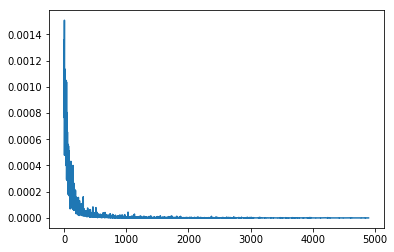

In [17]:
plt.plot(dl[100:])

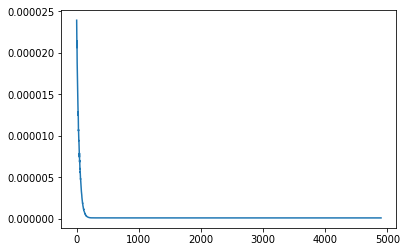

In [18]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

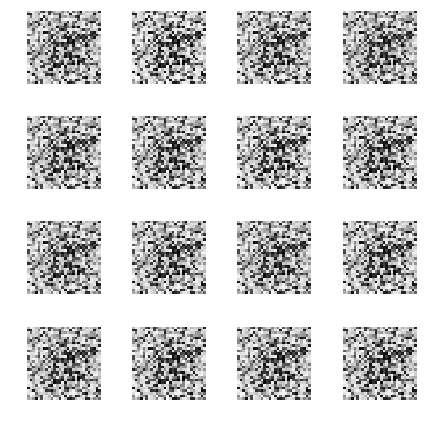

In [22]:
plot_gen(MLP_G)

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Add see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [130]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [131]:
CNN_G = Sequential([
    Dense(512*7*7, input_shape=(100,)),
    LeakyReLU(),
    BatchNormalization(),
    Reshape((7, 7, 512)),
    
    keras.layers.UpSampling2D(size=(2, 2), data_format=None),
    Conv2D(64, (3,3), strides=(1,1), padding='same'),
    LeakyReLU(),
    BatchNormalization(),
    keras.layers.UpSampling2D(size=(2, 2), data_format=None),
    Conv2D(32, (3,3), strides=(1,1), padding='same'),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(1, (1,1), strides=(1,1), padding='same', activation='sigmoid'),
])
CNN_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 25088)             0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 25088)             100352    
_________________________________________________________________
reshape_34 (Reshape)         (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_95 (UpSampling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 14, 14, 64)        294976    
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 14, 14, 64)        0         
__________

The discriminator uses a few downsampling steps through strided convolutions.

In [132]:
def modified_binary_crossentropy(target, output):
    #output = K.clip(output, _EPSILON, 1.0 - _EPSILON)
    #return -(target * output + (1.0 - target) * (1.0 - output))
    return K.mean(target*output)

In [133]:
CNN_D = Sequential([
    Conv2D(256, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(512, (3,3), strides=(2,2), padding='same'),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(1, activation='sigmoid')
])
# CNN_D.compile(keras.optimizers.RMSprop(1e-4), loss=[modified_binary_crossentropy])
CNN_D.compile(SGD(clipvalue=0.01), loss=[modified_binary_crossentropy])
CNN_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 7, 7, 512)         1180160   
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_64 (Dense)             (None, 256)               6422784   
__________

We train D a "little bit" so it can at least tell a real image from random noise.

In [134]:
a = CNN_G.predict(noise(sz))
a.shape

(300, 28, 28, 1)

In [135]:
np.random.permutation(X_train)[:sz].shape

(300, 28, 28, 1)

In [136]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, nb_epoch=1, verbose=2)

/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
0s - loss: 0.0479


In [137]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(keras.optimizers.RMSprop(1e-4), loss=[modified_binary_crossentropy])

In [138]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively.

In [139]:
dl,gl = train(CNN_D, CNN_G, CNN_m, 2500)

100%|██████████| 2500/2500 [03:35<00:00, 11.61it/s]


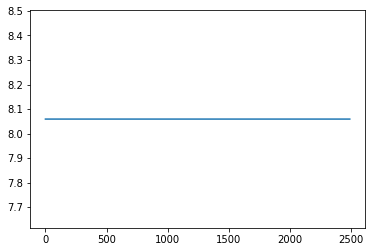

In [122]:
plt.plot(dl[10:])

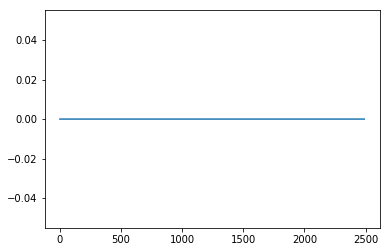

In [123]:
plt.plot(gl[10:])

Better than our first effort, but still a lot to be desired:...

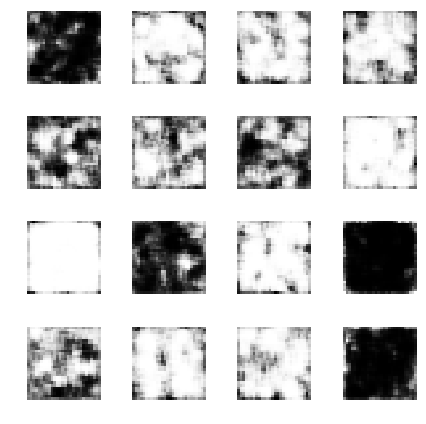

In [124]:
plot_gen(CNN_G)

## End